# Music Taste Analysis

So I've gotten annoyed with people asking me what sort of music I like in the past. This notebook represents my effort to once and for all answer the question, because, yes, I regard it to be this complicated.

### How to Use

My first pass at this depended upon [Watsonbox's Exportify](https://github.com/watsonbox/exportify), but I decided I didn't like his version because of bugs and inadequate output detail. So I [went and forked it](https://github.com/pavelkomarov/exportify), cleaned up [the](https://github.com/pavelkomarov/exportify/blob/master/app.html) [code](https://github.com/pavelkomarov/exportify/blob/master/exportify.js), and [hosted it](https://pavelkomarov.com/exportify/app) myself.

As such, the code here depends on `.csv` inputs in the format output by [my version](https://pavelkomarov.com/exportify/app).
1. To get started, hop on over there, sign in to Spotify to give the app access to your playlists, and export whatever you like.
2. Next, download this `.ipynb` file, put it in the same place as the `.csv` you just downloaded.
3. Open a terminal in that directory, `python3 -m notebook`, and open the `.ipynb`.
4. Update the `filename` variable in the first code cell to point to your playlist instead, and `shift+enter` in each following code cell to generate the corresponding plot.

### Analysis

For years I've been accumulating my favorite songs in a single master playlist called `music that tickles my fancy`. As of writing it is more than 2600 very thoroughly-vetted songs. This is what I'll be analyzing.

In [6]:
filename = 'music_that_tickles_my_fancy.csv'

from matplotlib import pyplot
import pandas
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

# read the data
data = pandas.read_csv(filename)
print("total songs:", data.shape[0])
print(data[:3])

total songs: 2625
                            Spotify URI                  Track Name  \
0  spotify:track:3T9HSgS5jBFdXIBPav51gj  Fanfare for the Common Man   
1  spotify:track:2bdZDXDoFLzazaomjzoER8            Highschool Lover   
2  spotify:track:1fE3ddAlmjJ99IIfLgZjTy             I Need a Dollar   

                                          Album Name  Duration (ms)  \
0  Copland Conducts Copland - Expanded Edition (F...         196466   
1                                    Virgin Suicides         162093   
2                                    I Need A Dollar         244373   

   Popularity Release Date                           Artist Name(s)  \
0          38         1963  Aaron Copland,London Symphony Orchestra   
1           0         2000                                      Air   
2           3   2010-03-16                               Aloe Blacc   

               Added By              Added At  \
0  spotify:user:pvlkmrv  2014-12-28T00:57:17Z   
1  spotify:user:pvlkmrv  2014

### Artist Bar Chart

Number of songs binned by artist. 

number of unique artists: 975


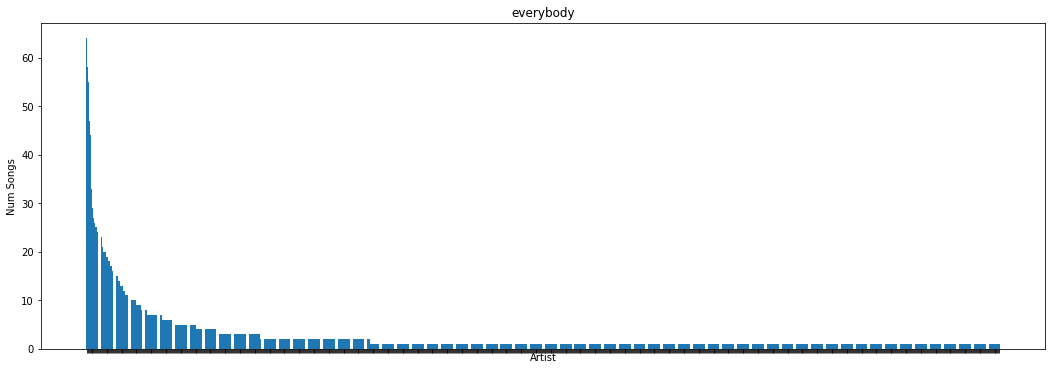

In [4]:
# count songs per artist
artists = defaultdict(int)
for i,song in data.iterrows():
	for musician in song['Artist Name(s)'].split(', '):
		artists[musician] += 1

# sort for histogram
artists = pandas.DataFrame(artists.items(), columns=['Artist', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False)
print("number of unique artists:", artists.shape[0])

pyplot.figure(1, figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody')
pyplot.show()

It seems to follow a Pareto distribution. Let's try to fit one.

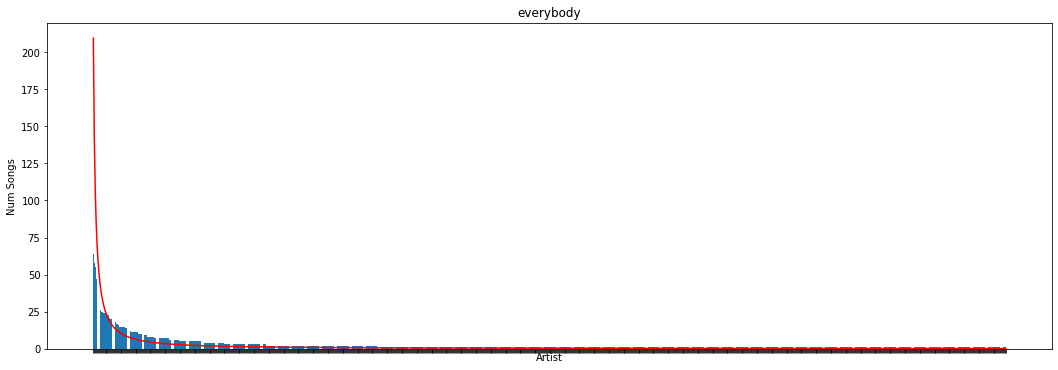

In [9]:
# Let's find the best parameters. Need x, y data 'sampled' from the distribution for
# parameter fit.
y = []
for i in range(artists.shape[0]):
	for j in range(artists['Num Songs'][i]):
		y.append(i) # just let y have histogram_index[artist] repeated for each song 
# The documentation is pretty bad, but this is okay:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(artists.shape[0]), *param[:-2], loc=param[-2],
                                  scale=param[-1])
# param = gamma.fit(y, 100) # gamma fits abysmally; see for yourself by uncommenting
# gamma_fitted = len(y)*gamma.pdf(range(artists.shape[0]), *param[:-2], loc=param[-2],
#                                 scale=param[-1])

pyplot.figure(2, figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
#pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody')

Best fit is still too sharp for the data, and I tried for a good long while to get it to fit better, so I conclude this doesn't *quite* fit a power law.

Let's plot the top 50 artists so we can actually read who they are.

Text(0.5, 1.0, 'top 50')

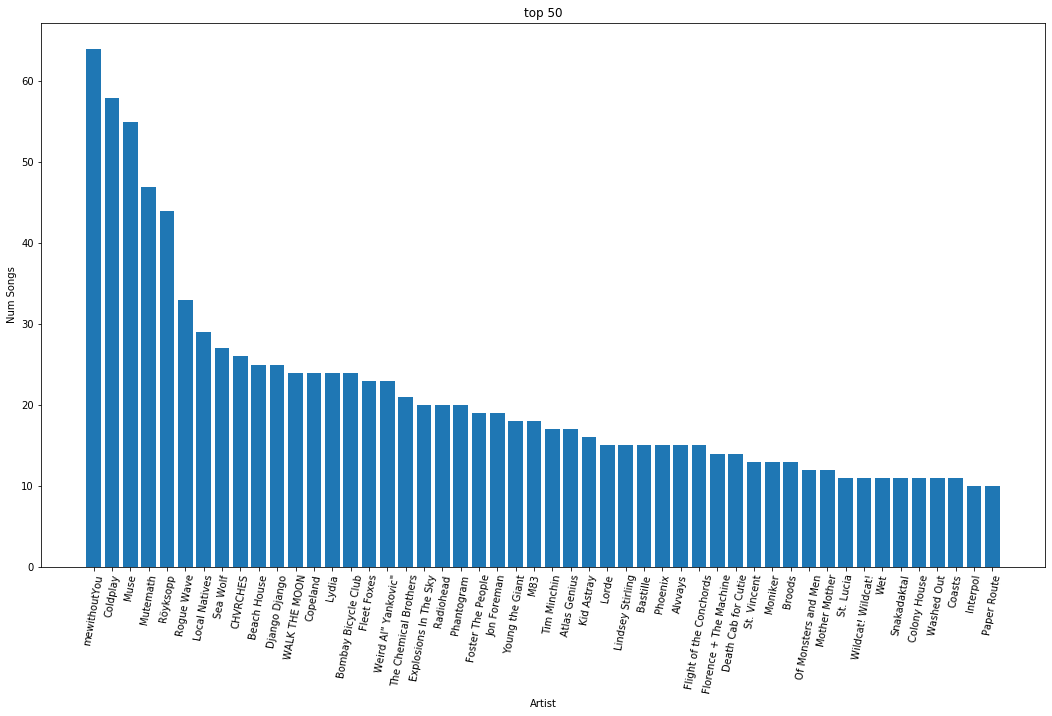

In [7]:
# My top 20 artists by song count
pyplot.figure(2, figsize=(18, 10))
pyplot.bar(artists['Artist'][:50], artists['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('top 50')

### Volume Added Over Time

My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

/home/pavel/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'volume added over time')

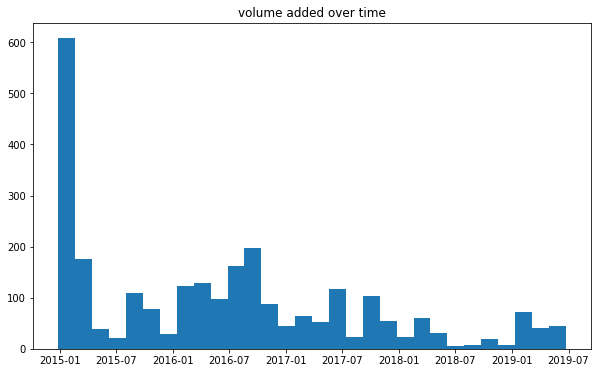

In [10]:
# Plot of added volume over time
parse_date = lambda d:(int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(3, figsize=(10, 6))
pyplot.hist([date(*parse_date(d)) for d in data['Added At']], bins=30)
pyplot.title('volume added over time')

The initial spike is from when I first stared using Spotify as the home for this collection and manually added hundreds from my previous list.